<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-WDaugherty/blob/main/5_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Quantization**


## 5.0 Setup Capabilities

In [1]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-WDaugherty' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-WDaugherty
M	2_size_estimator_and_profiler.ipynb
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 9), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (14/14), 238.84 KiB | 134.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a2-WDaugherty
   8ebb3a9..5c2e10b  main       -> origin/main
Updating 8ebb3a9..5c2e10b
Fast-forward
 3_training_and_analysis.ipynb       | 1784 ++++++++++++++++++++++++++++-------
 3_training_and_analysis_bonus.ipynb | 1670 ++++++++++++++++++++++++++++++++
 src/bonus_constants.py              |    2 +-
 3 files changed, 3118 insertions(+), 338 deletions(-)
 

In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Please verify the cell below prints out the github repository.

In [5]:
!ls '{PROJECT_ROOT}'

1_audio_preprocessing.ipynb	     4_model_conversion.ipynb	      images
2_size_estimator_and_profiler.ipynb  5_quantization.ipynb	      README.md
3_training_and_analysis_bonus.ipynb  6_pruning.ipynb		      src
3_training_and_analysis.ipynb	     arduino_nano_33_ble_tutorial.md  tests


### Install required packages

In [6]:
# Install libraries
!pip install tqdm
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import code dependencies

In [7]:
# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy
import os

import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will 
# reproduce the training and testing results  
random_seed = RANDOM_SEED
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 5.1 Define Quantization Functions

There are some test cases in the `tests` folder to verify basic functionality of your implemented functions--these will be run automatically every time you check in your code. Additionally, we've left some simple tests in this notebook as well for you to try things out.



#### TODO 0: Implement the backward pass of `ste_round` function in `src/quant.py`

In [ ]:
# add a test if you like. There's already one under tests/

In [8]:
%cd /content/gdrive/MyDrive/ece5545/a2-WDaugherty/src
!git pull 

/content/gdrive/MyDrive/ece5545/a2-WDaugherty/src
Already up to date.



#### TODO 1: Implement the `linear_quantize` function in `src/quant.py`


In [9]:
from src.quant import linear_quantize

# Mini test case for linear_quantize
with torch.no_grad():
    x = torch.tensor([2, -0.5, 0., 1.])
    scale = 1
    zero = 0
    y = linear_quantize(x, scale, zero)
    print(y) # y should be [2, 0, 0, 1]

tensor([2., 0., 0., 1.])


#### TODO 2: Implement the `SymmetricQuantFunction` forward function in `src/quant.py`


In [10]:
from src.quant import SymmetricQuantFunction

quant_f = SymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)      # [1, 0, 0, 1]
print(x.grad) # [2, 0, 0, 2]

tensor([1., -0., 0., 1.], grad_fn=<SymmetricQuantFunctionBackward>)
tensor([2., -0., 0., 2.])


#### TODO 3: Implement the `AsymmetricQuantFunction` forward function in `src/quant.py`

In [11]:
from src.quant import AsymmetricQuantFunction

quant_f = AsymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)      # [2, 0, 0, 1]
print(x.grad) # [4, 0, 0, 2]

tensor([2., -0., 0., 1.], grad_fn=<AsymmetricQuantFunctionBackward>)
tensor([4., -0., 0., 2.])


#### TODO 4: Finish the Implement of `get_quantization_params` function in `src/quant.py`

In [12]:
from src.quant import QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)
print(qconfig.get_quantization_params(x.min(), x.max())) # Expect: 0.2857, 0

qconfig = QConfig(quant_bits=4, is_symmetric=False)
print(qconfig.get_quantization_params(x.min(), x.max())) # Expect: 0.1667, 3.

(tensor(0.2857), tensor(0.))
(tensor(0.1667), tensor(3.))


#### TODO 5: Implement the `quantize_weights_bias` function in `src/quant.py`

In [13]:
from src.quant import quantize_weights_bias, QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)

w1 = nn.Parameter(torch.tensor([2, -0.5, 0., 1.]))
qw1 = quantize_weights_bias(w1, qconfig)
print(qw1.data) # [7, -2, 0, 3]

w2 = nn.Parameter(torch.tensor([2.5, -1, 0., 1.5]))
qw2 = quantize_weights_bias(w2, qconfig)
print(qw2.data) # [7, -3, 0, 4]

tensor([ 7., -2.,  0.,  3.])
tensor([ 7., -3.,  0.,  4.])


## 5.2 Quantization Function for Linear and Convolution Layer

#### TODO 6: Finish the implementation of `conv2d_linear_quantized` function in `src/quant.py`

In [14]:
import torch.nn as nn
from src.quant import QuantWrapper

layer = nn.Linear(2, 2)
layer.weight.data = torch.tensor([[0.1, 0.1], [-0.1, 0.1]]).view(2, 2).float()
layer.bias.data = torch.tensor([1, 2]).view(*layer.bias.shape).float()
x = torch.tensor([[0., 1]])
print(layer(x)) # [1.1, 2.1]

quant_layer = QuantWrapper(
    layer, 
    QConfig(quant_bits=4, is_symmetric=True), 
    QConfig(quant_bits=4, is_symmetric=True), 
    QConfig(quant_bits=4, is_symmetric=True))
print(quant_layer(x)) # [0.957, 2.1]


tensor([[1.1000, 2.1000]], grad_fn=<AddmmBackward0>)
tensor([[0.9571, 2.1000]], grad_fn=<AddmmBackward0>)


## 5.3 Prepare model for QAT (Quantization Aware Training)

### Get Audio Processor, Devices, Data Loader, and Model

NOTE: This is identical to section 2.2 .

In [15]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Load Pretrained Model for Quantization Aware Finetuning

In this notebook, we will load the previously trained 32-bits float model to finetune it in a quantizaiton-aware way. 



In [16]:
!ls {TORCH_DIR}

 4bitquant_0.pt		       model4.pt
 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'
 fp32_finetune_checkpoint.pt   quant_checkpoint.pt
 model_4bit.pt		       tinyconv_float32_init_seed0_91.45%_0.pt
 model_4bitquant_0.pt	       tinyconv_float32_init_seed0_91.81%_0.pt
 model_4.pt


### **TODO: Replace the torch_path model with the model you created in the last section.** 

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [17]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_91.81%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Define settings for weight and activation quantization 

In [ ]:
# We choose 4 bit quantization as an example because accuracy improvements will 
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 4
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

### Prepare quantization aware training model

In [ ]:
from src.quant import quantize_model
qat_model_nbit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_nbit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_m

##  5.4 Finetuning

In this training, we will finetune the 32-bits float pretrained model. The goal is to finetune the weights of the 32-bits float model such that the resulted model will have better accuracy after quantization.

### Quantization Aware Finetuning

In [23]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None, 
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, 
                 epoch=None, loader_type='Test')
            
            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)
                
            # Update epoch pbar
            pbar.update(1)



In [ ]:

verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
qat_model_nbit.to(device)
run_training(
    model=qat_model_nbit, data_loaders=data_loaders, 
    n_epoch=n_epoch, log_interval=log_interval, 
    optimizer=optimizer_quant, scheduler=None, 
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

### Finetune the Float Model

For fair comparison, we conduct the same funetuning for the float model.

In [ ]:
# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.0001)

checkpoint_path = os.path.join(TORCH_DIR, "fp32_finetune_checkpoint.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders, 
    n_epoch=n_epoch, log_interval=log_interval, 
    optimizer=optimizer_fp32, scheduler=None, 
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 90.62%, Train loss = 0.326
Val Acc Epoch 2 = 91.3%, Train loss = 0.314
Val Acc Epoch 3 = 91.37%, Train loss = 0.332
Val Acc Epoch 4 = 91.45%, Train loss = 0.308
Val Acc Epoch 5 = 90.92%, Train loss = 0.299
Val Acc Epoch 6 = 91.67%, Train loss = 0.312
Val Acc Epoch 7 = 91.67%, Train loss = 0.305
Val Acc Epoch 8 = 91.97%, Train loss = 0.312
Val Acc Epoch 9 = 91.45%, Train loss = 0.308
Val Acc Epoch 10 = 90.4%, Train loss = 0.302
Val Acc Epoch 11 = 91.75%, Train loss = 0.302
Val Acc Epoch 12 = 91.3%, Train loss = 0.308
Val Acc Epoch 13 = 90.4%, Train loss = 0.304
Val Acc Epoch 14 = 91.3%, Train loss = 0.293
Val Acc Epoch 15 = 91.75%, Train loss = 0.3
Val Acc Epoch 16 = 91.6%, Train loss = 0.3
Val Acc Epoch 17 = 91.3%, Train loss = 0.307
Val Acc Epoch 18 = 90.7%, Train loss = 0.299
Val Acc Epoch 19 = 91.37%, Train loss = 0.289
Val Acc Epoch 20 = 90.7%, Train loss = 0.294
Val Acc Epoch 21 = 92.2%, Train loss = 0.293
Val Acc Epoch 22 = 91.67%, Train loss = 0.298
Val Acc Epo

## 5.5 Testing

We will compute the accuracy of the finetuned model in train/val/test set in this section.
Note that this is not the final accuracy we want the model to perform well on. 
We would like our quantized-aware-finetuned model to perform well when quantized into integer. 
But the training/validation/testing accuracy of these model in quantization simulation model is still worth looking at for sanity checking purpose.

Train size: 10556 Val size: 1333 Test size: 1368


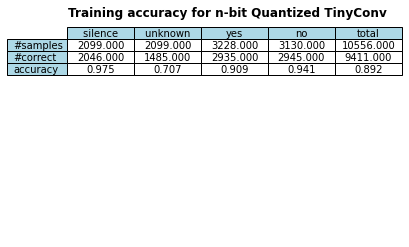

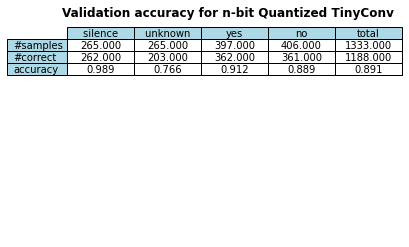

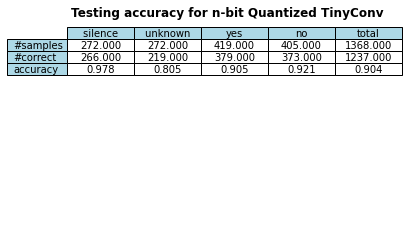

0.9042397660818714

In [ ]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_nbit, audio_processor, device,
    "Training", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_nbit, audio_processor, device,
    "Validation", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_nbit, audio_processor, device,
    'Testing', 'n-bit Quantized TinyConv', "float")

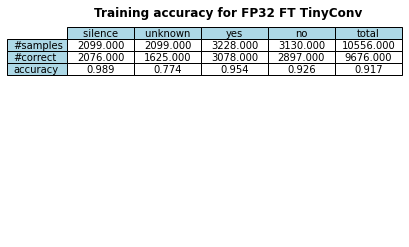

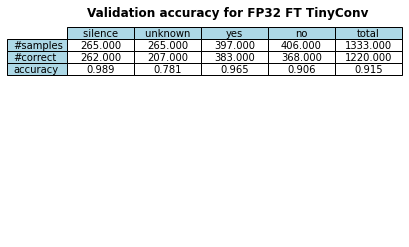

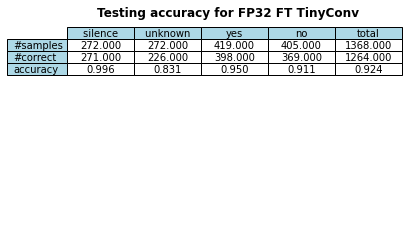

In [ ]:
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "Training", 'FP32 FT TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "Validation", 'FP32 FT TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'Testing', 'FP32 FT TinyConv', "float")

## 5.6 Saving the Trained Model

In [ ]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_nbit_float = dequantize_model(qat_model_nbit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f"model_{QUANT_BITS}bit{file_name}.pt")
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_nbit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/model_4bitquant_0.pt'

In [ ]:

!ls {TORCH_DIR}

 4bitquant_0.pt		       model4.pt
 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'
 fp32_finetune_checkpoint.pt   quant_checkpoint.pt
 model_4bit.pt		       tinyconv_float32_init_seed0_91.45%_0.pt
 model_4bitquant_0.pt	       tinyconv_float32_init_seed0_91.81%_0.pt
 model_4.pt


## 5.7 Understanding and Evaluate the Effectiveness of Quantization-Aware Training (QAT)

### Model conversion: Quantized/Float Fine-tuning Model Converted to Integer Models

In [ ]:
from src.quant_conversion import convert_to_int

In [ ]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_nbit = convert_to_int(
    qat_model_nbit, QUANT_BITS, dtype=torch.int32) 
    
# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32) 
  
# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_nbit = dequantize_model(qat_model_nbit)

print(int_model_nbit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
Sequential(
  (quant): Quant(): qconfig=quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None ; dtype=torch.int32
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv_quant): Quant(): qconfig=quant_bits=4, quant_mode=asymmetric, prev_scale=1.7005208730697632, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125 ; dtype=torch.int32
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): R

In [ ]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_nbit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.weight: min=-8; max=7; dtype=torch.int32; shape=torch.Size([8, 1, 10, 8])
conv.bias: min=-8; max=7; dtype=torch.int32; shape=torch.Size([8])
fc.weight: min=-8; max=7; dtype=torch.int32; shape=torch.Size([4, 4000])
fc.bias: min=-4; max=4; dtype=torch.int32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=25.546875; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv_quant: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-3079; max=293; dtype=torch.int32; shape=torch.Size([1, 8, 25, 20])
output of relu: min=0; max=293; dtype=torch.int32; shape=torch.Size([1, 8, 25,

### Compare the Performance Between Integer Models from Float/Quantized-Aware Finetuning

In [ ]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model 
# Percentage of same predictions shows how "quantization aware" the float point model is 
_ = compare_model(test_loader, float_model_nbit, int_model_nbit)
_ = compare_model_mse(test_loader, float_model_nbit, int_model_nbit)

The models have 98.465% same predictions, 
Model1 predicts 90.205% of the samples correctly, 
Model2 predicts 89.839% of the samples correctly
MSE between two models' prediction: 0.0063


In [ ]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model)

The models have 93.567% same predictions, 
Model1 predicts 91.155% of the samples correctly, 
Model2 predicts 89.620% of the samples correctly
MSE between two models' prediction: 0.0191


In [31]:
def report_stuff(bits):
    qat_accs = []
    ptq_accs = []
    for bit in bits:
        model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
                              n_input=1, n_output=audio_processor.num_labels)
        # Settings for activations quantization: n-bit asymmetric quantization
        a_qconfig = QConfig(quant_bits=bit, is_symmetric=False)
        # Settings for weights quantization: n-bit symmetric quantization
        w_qconfig = QConfig(quant_bits=bit, is_symmetric=True)
        # Settings for bias quantization: n-bit symmetric quantization
        b_qconfig = QConfig(quant_bits=bit, is_symmetric=True)
        qat_model_nbit = quantize_model(model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)
        verbose = False
        log_interval = 100
        num_batches = len(train_loader)
        n_epoch = 30
        print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

        # Create optimizer
        optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.001)
        print(optimizer_quant.state_dict())

        checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint" + str(bit) + ".pt")
        qat_model_nbit.to(device)
        
        run_training(
            model=qat_model_nbit, data_loaders=data_loaders, 
            n_epoch=10, log_interval=log_interval, 
            optimizer=optimizer_quant, scheduler=None, 
            resume=False,
            checkpoint_path=checkpoint_path,
            verbose=verbose
        )
        # Quantized integer model of qat_model_nbit (quantized aware finetuning model)
        int_model_nbit = convert_to_int(
            qat_model_nbit, bit, dtype=torch.int32) 
            
        # Post quantized model of model_fp32 (full-precision finetuned model)
        post_quant_model = convert_to_int(
            model_fp32, bit, dtype=torch.int32) 
        _, qat_acc, ptq_acc = compare_model(test_loader, int_model_nbit, post_quant_model)
        print(qat_acc, ptq_acc)
        qat_accs.append(qat_acc)
        ptq_accs.append(ptq_acc)
    return qat_accs, ptq_accs

In [32]:
from src.quant import *
from src.quant_conversion import *
from src.train_val_test_utils import *
a, b = report_stuff([2]) #Can be done for all the int values between 1 and 8

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/10 [00:00<?, ?it/s]

Val Acc Epoch 1 = 21.38%, Train loss = 57.005
Val Acc Epoch 2 = 23.33%, Train loss = 299.529
Val Acc Epoch 3 = 20.63%, Train loss = 777.07
Val Acc Epoch 4 = 20.48%, Train loss = 1546.044
Val Acc Epoch 5 = 21.46%, Train loss = 2551.348
Val Acc Epoch 6 = 20.78%, Train loss = 3793.338
Val Acc Epoch 7 = 21.38%, Train loss = 5431.325
Val Acc Epoch 8 = 21.31%, Train loss = 7181.111
Val Acc Epoch 9 = 20.33%, Train loss = 9012.116
Val Acc Epoch 10 = 21.38%, Train loss = 11353.943
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
The models have 89.693% same predictions, 
Model1 predicts 21.272% of the samples correct

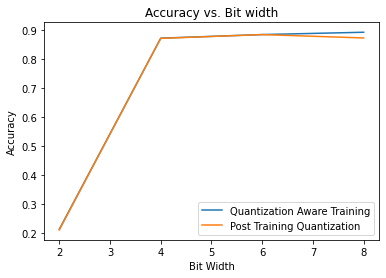

In [37]:
import matplotlib.pyplot as plt
bits = [2, 4, 6, 8]
qat = [0.21271929824561403, 0.8728070175438597, 0.8852339181286549, 0.8932748538011696]
ptq = [0.21052631578947367, 0.8720760233918129, 0.8852339181286549, 0.8735380116959064]

plt.figure()
plt.plot(bits, qat, label="Quantization Aware Training")
plt.plot(bits, ptq, label="Post Training Quantization")
plt.title("Accuracy vs. Bit width")
plt.xlabel("Bit Width")
plt.ylabel("Accuracy")
plt.legend()
plt.show()